In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 5
Title         = 'Synthetic Regression'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [5]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.2206760597859233


MLPRegressor(random_state=RandomState(MT19937) at 0x197A7A69840)

In [6]:
Reg_Data.Random_Forest()

0.2597612125940616


RandomForestRegressor(random_state=RandomState(MT19937) at 0x197A7A69840)

In [7]:
Reg_Data.GP()

-1.278400758950899


GaussianProcessRegressor()

In [8]:
Reg_Data.L_Regression()

0.28098814065961164


LinearRegression()

In [9]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [10]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [11]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [12]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [  5.49323216  11.63530537   7.17475037  12.8296047    7.36493077
  13.72683768 -15.92707099  16.03495948]
Std 0:  [4.30095261 5.74221143 4.29590393 4.73631928 3.27514284 1.60549058
 2.18650121 4.60695649]


In [13]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics(feature_names = Reg_Data.get_features(),
                                 mode          = Reg_Data.get_mode(),
                                 X_train_std   = Reg_Data.get_X_train_std(),
                                 N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics(feature_names = Reg_Data.get_features(),
                                 mode          = Reg_Data.get_mode(),
                                 X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model(),
                         consistancy   = consistancy)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None,
                           model         = URM_Exp_2.get_exp_model())
    


INSTANCE:  0
[-93.43224348] [-9.34322435e+01  1.00000004e-05] [-93.43224349]
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  1
[-58.53231512] [-5.85323151e+01  1.00000004e-05] [-58.53231512]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  2
[-91.18215509] [-9.11821551e+01  1.00000004e-05] [-91.18215509]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  3
[-96.26895872] [-9.62689587e+01  1.00000004e-05] [-96.26895873]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  4


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-19.91640136] [-1.99164014e+01  1.00000004e-05] [-19.91640136]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

In [14]:
import matplotlib.pyplot as plt


In [15]:
print(f_predict)
print(e_predict)


[-17.11122721]
[-1.71112272e+01  9.86863643e-06]


In [16]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


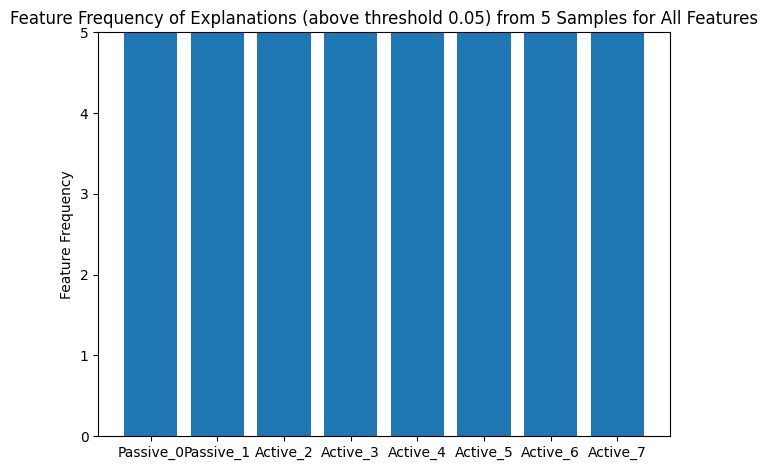

In [17]:
Reg_Stats.Frequency_Plot()


In [18]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           73.90416065396764  :  197.7889662539345  :  95.40639077283934
y - exp(x):          73.90416065880969  :  197.78896633772564  :  95.40639078539878
BB(x) - exp(x):      7.654062983419863e-09  :  1.5059096986798755e-17  :  1.255943971045781e-08
Average exp(x) var:  1.0000000413701846e-05


In [19]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.5571428571428572
Mean Jaccard Distance:    0.4428571428571428


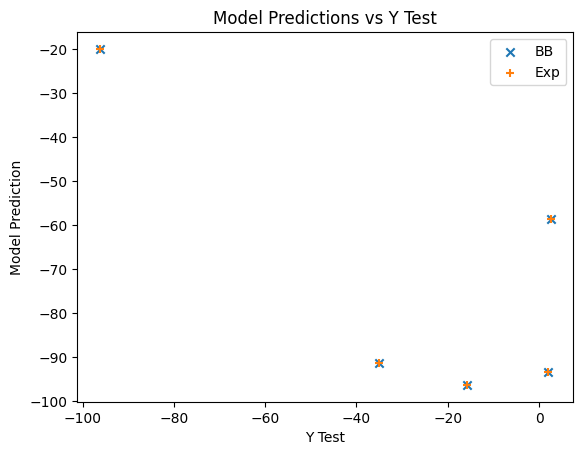

In [20]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 8)


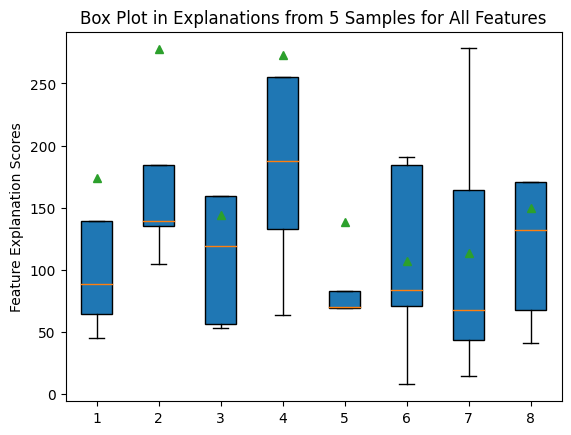

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [21]:
Reg_Stats.Box_Plot()


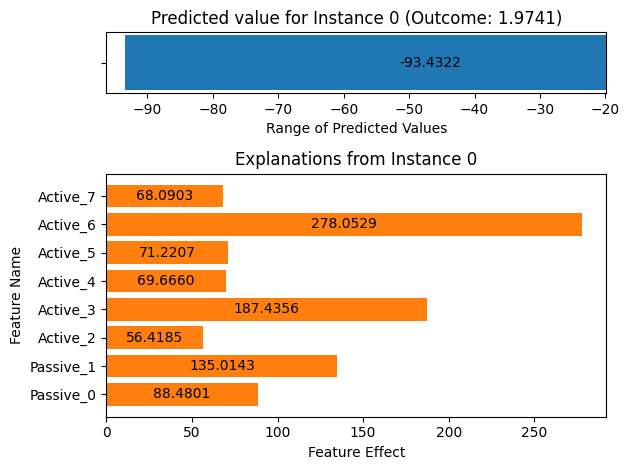

In [22]:
Reg_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[ 50.85076723 114.57843109  58.75642506  77.11886775  40.20767746
   8.72352107  17.25282767  40.0641919 ]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[2.85060171 3.64367838 3.02243898 3.76487609 3.17752044 2.70421606
 2.77803072 2.89978558]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[2.57240288 8.27895498 3.94420749 7.78039996 4.69036343 1.28921074
 1.83330214 2.17557228]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.06107767 0.52790814 1.12238977 0.89563371 0.03335537 1.36404181
 1.47167677 1.52391676]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[1.73286418e-01 4.76930578e+00 1.31237519e-05 5.69965883e-01
 9.96890845e-01 3.26610043e-02 1.08817931e+00 3.69697640e-01]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-1.46232386  3.77018057  1.80282528 -4.4239109  -2.73442564  0.59750843
  0.43094077  2.52855727]


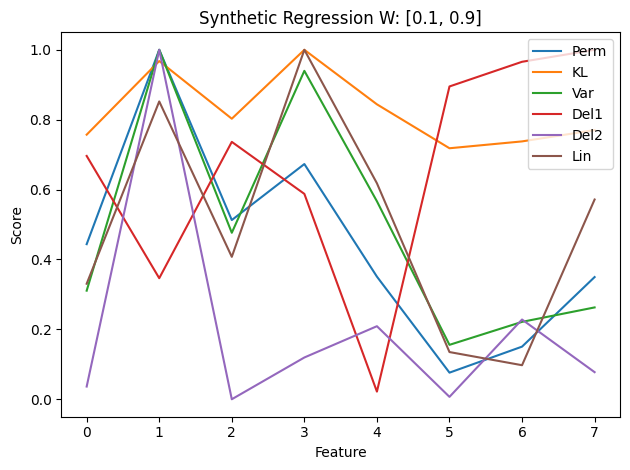

In [29]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.81903808e-02  9.98305504e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.81903808e-02  9.98305504e-01  1.41421323e-05  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

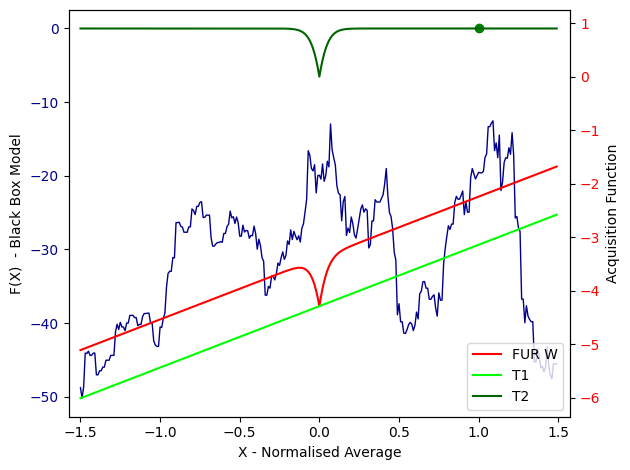

In [32]:
acq_data.plot_point(0)

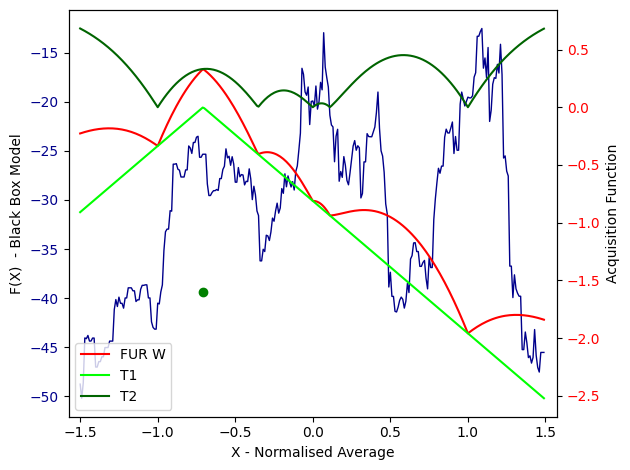

In [33]:
acq_data.plot_point(5)

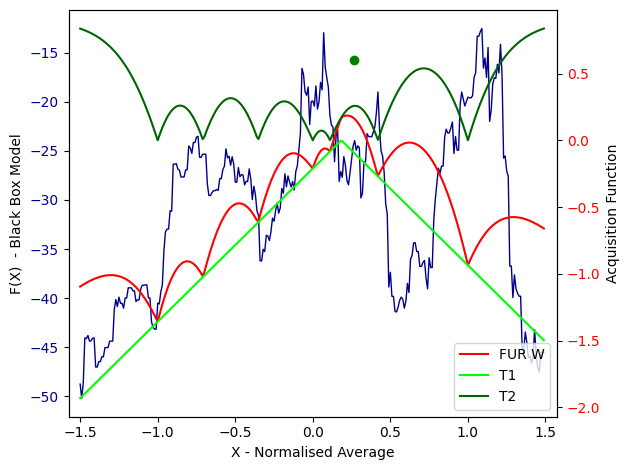

In [34]:
acq_data.plot_point(10)

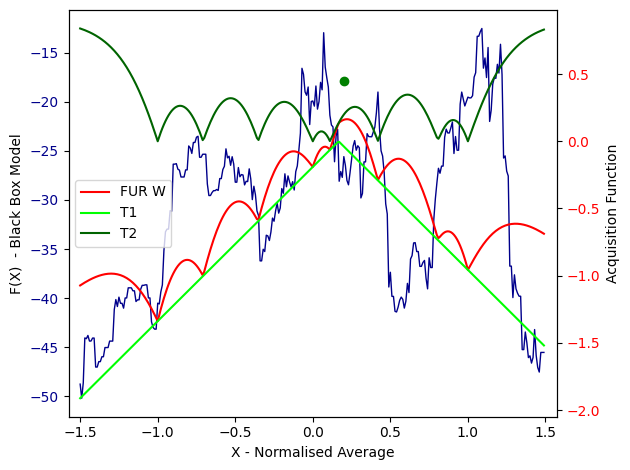

In [35]:
acq_data.plot_point(15)

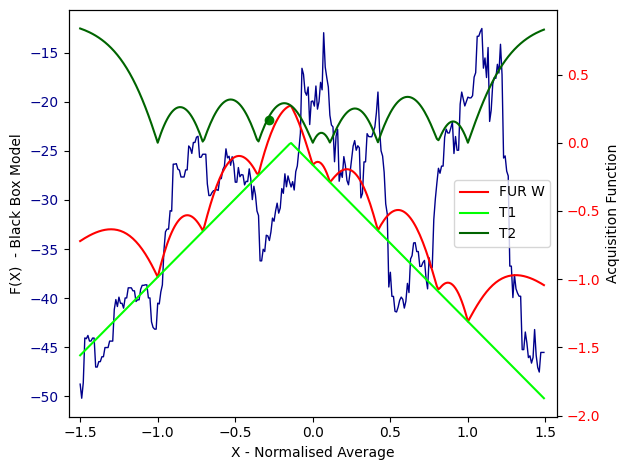

In [36]:
acq_data.plot_point(19)

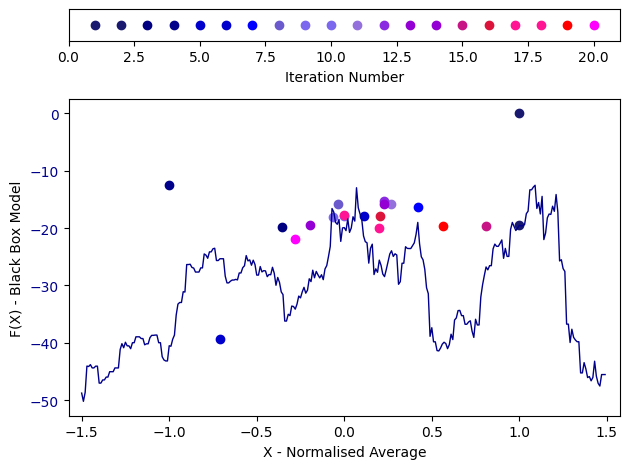

In [37]:
acq_data.plot_all()

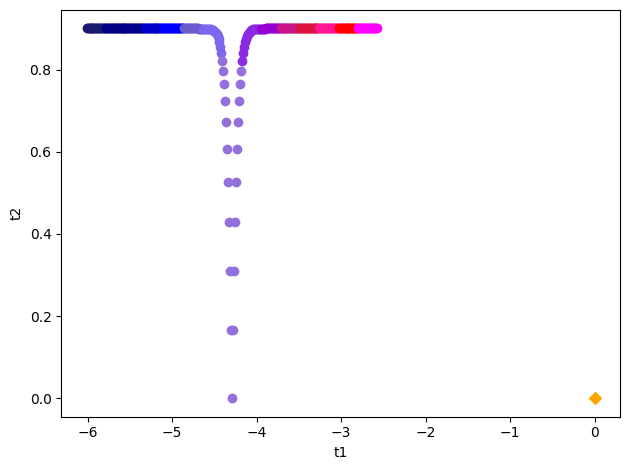

In [38]:
acq_data.plot_t1_t2(0)

In [39]:
#acq_data.plot_t1_t2(1)

In [40]:
#acq_data.plot_t1_t2(2)

In [41]:
#acq_data.plot_t1_t2(3)

In [42]:
#acq_data.plot_t1_t2(4)

In [43]:
#acq_data.plot_t1_t2(5)

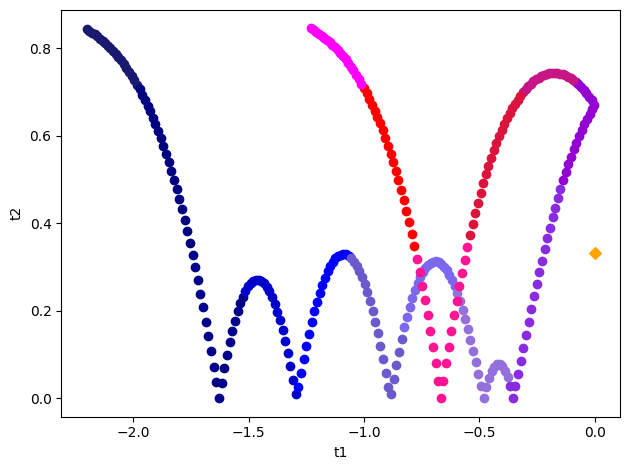

In [44]:
acq_data.plot_t1_t2(6)

In [45]:
#acq_data.plot_t1_t2(7)

In [46]:
#acq_data.plot_t1_t2(8)

In [47]:
#acq_data.plot_t1_t2(9)

In [48]:
#acq_data.plot_t1_t2(10)

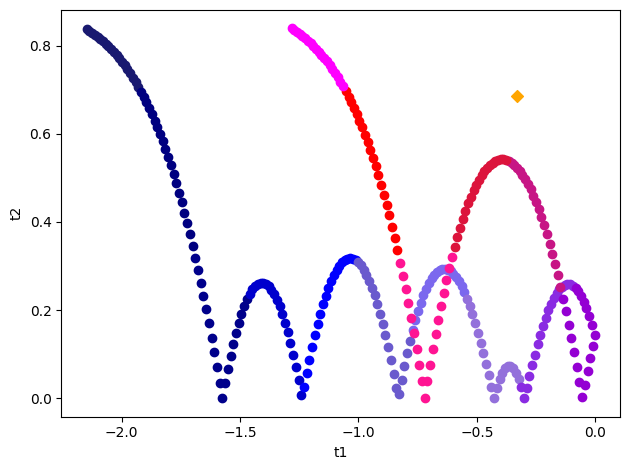

In [49]:
acq_data.plot_t1_t2(11)

In [50]:
#acq_data.plot_t1_t2(12)

In [51]:
#acq_data.plot_t1_t2(13)

In [52]:
#acq_data.plot_t1_t2(14)

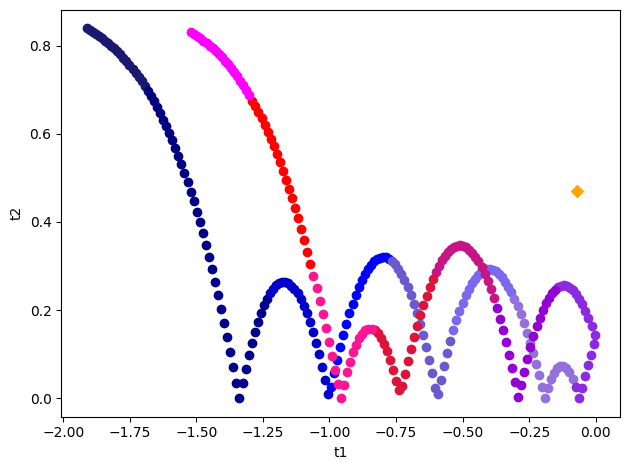

In [53]:
acq_data.plot_t1_t2(15)

In [54]:
#acq_data.plot_t1_t2(16)

In [55]:
#acq_data.plot_t1_t2(17)

In [56]:
#acq_data.plot_t1_t2(18)

In [57]:
#acq_data.plot_t1_t2(19)

In [58]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

Average, Var, and Max Differences:
y - BB(x):           73.90416065396764  :  197.7889662539345  :  95.40639077283934
y - exp(x):          73.90416065880969  :  197.78896633772564  :  95.40639078539878
BB(x) - exp(x):      7.654062983419863e-09  :  1.5059096986798755e-17  :  1.255943971045781e-08
Average exp(x) var:  1.0000000413701846e-05
Fidelity:  2.439389543582372


In [59]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.48
Mean Jaccard Distance:    0.5200000000000001
Jaccard:  0.48


In [60]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Scores:  [174.25168446 277.64875837 144.06932378 273.10454615 138.61588968
 107.49064504 113.57954706 149.57261046]
Mean Coeffs:  [ 0.          0.          4.92069154 -8.03269747 -3.94160503  9.98383512
  6.09914275 -2.00567058]
Coeff Ratio:  [ 0.          0.          0.03415503 -0.02941254 -0.02843545  0.09288097
  0.05369931 -0.01340934]


In [61]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

Delete 1 Variance:  [1.54508848e-38 5.00249997e-24 7.63731005e-38 6.75478105e-36
 3.19760162e-39 9.05265103e-41 3.31562898e-39 8.14002484e-40]


N_Points:  25


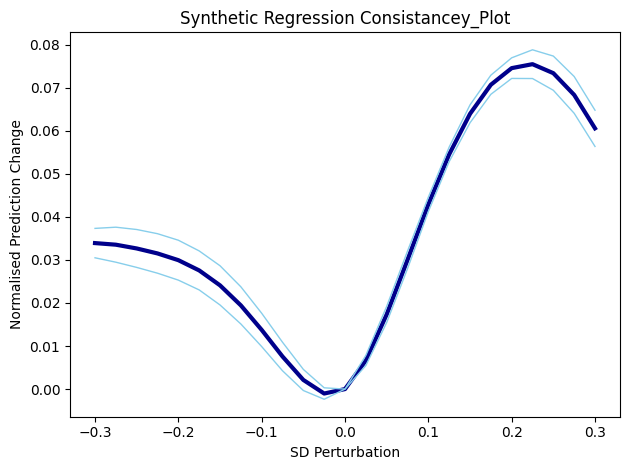

In [62]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [63]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

Score Diff Mean:  [1.01140147 1.61051963 0.83609193 1.58525902 0.80488676 0.62433826
 0.65966773 0.86783521]
Score Diff SD:    [1.06130046 1.59709214 0.59451534 1.36615826 0.88052979 0.40786186
 0.559621   0.60179051]
